<a href="https://colab.research.google.com/github/alonsomoros/colab/blob/main/2_3_1_Auto_encoders_variacionales_jdl_Mi_primer_VAE_con_Keras_Soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Mi primer AutoEncoder Variacional con Keras<a id="top"></a>

<i><small>Authors: Félix José Fuentes Hurtado<br>
Actualizado por JorgeDL Last update: 2024-10-09</small></i></div>

***

### Mi primer AutoEncoder Variacional con Keras

En este notebook vamos a ver cómo podemos implementar un autoencoder variacional paso a paso. Todos los ejemplos están extraídos del propio blog de Keras, aquí tenéis el [enlace](https://blog.keras.io/building-autoencoders-in-keras.html) para su consulta. También he extraído imágenes e información de [este](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) y [este](http://www.cs.us.es/~fsancho/?e=232) enlace que os dejo para vuestra consulta. Y [este](https://www.jeremyjordan.me/variational-autoencoders/) por si queréis ampliar con algo "más matemático".

Comenzemos recordando qué es un autoencoder variacional. Para ello, mirad la imagen siguiente:

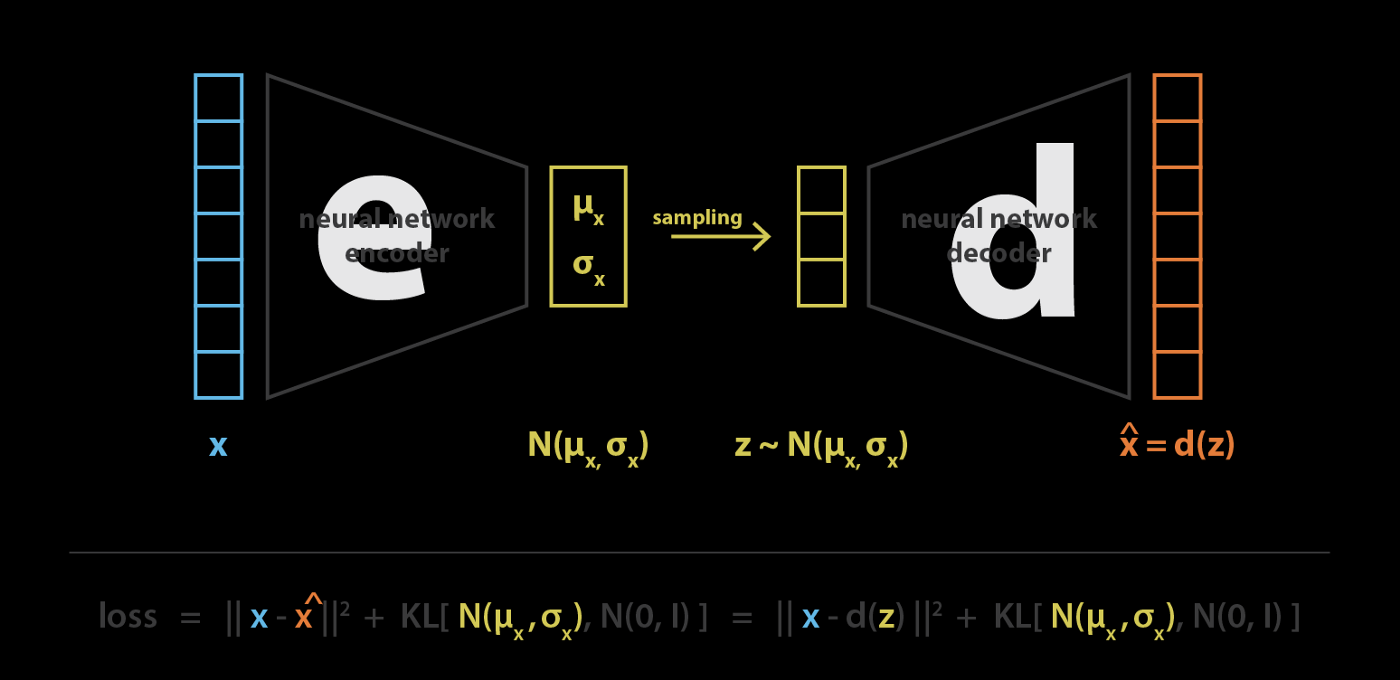

En ella podemos observar como, al igual que el autoencoder básico, consta de dos bloques: el encoder y el decoder.

Por una parte, el **encoder** toma los datos de entrada y los comprime en una representación mucho más compacta.

Por la otra, el **decoder** coge esa representación (o codificación) comprimida y trata de reconstruir los datos originales con el menor error posible.

La única diferencia es que el encoder, en este caso, no produce un "punto" en el espacio reducido, sino que produce una distribución de probabilidad. Es mediante el muestreo de esta distribución de probabilidad como somos capaces de regenerar los datos de entrada al introducirle la muestra obtenida al decoder.

Por comparación, si recordamos cómo funcionaba el autoencoder, tenemos que éste producía un código latente (discreto, determinista) y el propósito del autoencoder era reconstruir los datos de entrada a la salida, comprimiéndolos a este código latente.

Para ello, combiene recordar las funciones de pérdidas que se empleaban en los auto-encoders:

## Error de Reconstrucción

Al igual que las redes neuronales "simples", un autoencoder aprende a través de backpropagation. Sin embargo, en lugar de comparar los valores o etiquetas del modelo, comparamos los datos reconstruidos y los datos originales. Para ello, las dos funciones de pérdidas más empleadas son: el Error Cuadrático Medio/Absoluto y la entropía cruzada binaria/categórica (dependiendo del número de clases).

### Error Cuadrático Medio (MSE)

Como ya sabéis, una forma de realizar la reconstrucción es mediante el error cuadrático medio, el cual está dado por la siguiente ecuación:

$$L = \dfrac{1}{n}\sum_{i = 0}^{n}\big (\hat{x}_{i} - x_{i}\big) ^ {2}$$

donde $\hat{x}$ son los datos reconstruidos, mientras que $x$ son los datos originales.

### Mean Absoluto Error (MAE)

También existe la versión "absoluta":

$$L = \dfrac{1}{n}\sum_{i = 0}^{n}\big |\hat{x}_{i} - x_{i}\big|$$

donde $\hat{x}$ son los datos reconstruidos, mientras que $x$ son los datos originales.

### Entropía Cruzada Binaria (BCE)

Otra forma de medir el error de reconstrucción es mediante la entropía cruzada binaria (Binary Cross-Entropy - BCE) en el caso de datos binarios (siguen una distribución de Bernoulli, por lo tanto está función de pérdida es mayormente la más adecuada). BCE está dado por:

$$L = -\sum_{i = 0}^{n_{samples}} x_{i} \log \hat{x}_{i} + \big (1 - x_{i} \big)\log \big(1 - \hat{x}_{i}\big) $$
donde $\hat{x}$ son los datos reconstruidos, mientras que $x$ son los datos originales, e $i \in 0..n_{samples}$.

### Entropía Cruzada Categórica (BCE)

Exactamente lo mismo que la BCE, pero para problemas en los que tenemos más de 2 clases.

$$L = -\sum_{c=0}^{C}\sum_{i = 0}^{n_{samples}} x_{c,i} \log \hat{x}_{c,i} + \big (1 - x_{c,i} \big)\log \big(1 - \hat{x}_{c,i}\big) $$
donde $\hat{x}$ son los datos reconstruidos, mientras que $x$ son los datos originales, $i \in 0..n_{samples}$ y $C$ es el número clases.

## Autoencoders Variacionales (VAEs)

En el caso de los Auto-Encoders Variacionales tendremos, además, una función de pérdidas que se encargará de conseguir que las distribuciones normales con las que modelemos los datos sean las mejores posibles.

Para lograr esto, introducimos la divergencia de Kullback-Leibler en la función de pérdida. La divergencia KL entre dos distribuciones de probabilidad mide simplemente cuánto se alejan una de la otra. Minimizar la divergencia KL aquí implica optimizar los parámetros de la distribución de probabilidad (μ y σ) para que se asemejen de cerca a los de la distribución objetivo.

$$
L_{KL} = \sum_{i=1}^n \sigma_i^2 + \mu_i^2-log(\sigma_i) - 1
$$

En el caso de los VAEs, la pérdida KL es equivalente a la suma de todas las divergencias KL entre los componentes $X_i\sim N(\mu_i, \sigma_i)$ en X, y la normal estándar. Se minimiza cuando $\mu_i = 0$ y $\sigma_i = 1$.

De manera intuitiva, esta pérdida incentiva al codificador a distribuir todas las codificaciones (para todos los tipos de entradas, por ejemplo, todos los números MNIST) de manera uniforme alrededor del centro del espacio latente. Si intenta "engañar" al agruparlas en regiones específicas alejadas del origen, será penalizado.

A lo largo de esta práctica haremos lo siguiente:

* Empezaremos con un AutoEncoder Variacional muy simple, en el que tanto el encoder como el decoder tendrán una sola capa Densa.
* Adaptaremos el DC AE para convertirlo en variacional y lo usaremos para reducir el ruido presente en nuestras imágenes


**¡Comenzemos!**

Vamos a construir el AutoEncoder Variacional más simple posible:

In [ ]:
!pip install tensorflow==2.13
!pip install keras==2.13.1

   ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/524.1 MB 37.1 MB/s eta 0:00:12

In [ ]:
import keras
from keras import layers
from keras import backend as K

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

# encoder
inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])


# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')


In [ ]:
# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [ ]:
# loss function
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Ya tenemos definida la arquitectura. Ahora obtendremos los datos y entrenaremos el modelo:

In [ ]:
import numpy as np
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=30,
        batch_size=32,
        validation_data=(x_test, x_test))

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/30
1875/1875 [==============================] - 10s 4ms/step - loss: 188.7614 - val_loss: 169.7832
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 167.5595 - val_loss: 164.8567
Epoch 3/30
1875/1875 [==============================] - 11s 6ms/step - loss: 163.6938 - val_loss: 161.7220
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 160.9714 - val_loss: 159.9097
Epoch 5/30
1875/1875 [==============================] - 9s 5ms/step - loss: 159.4155 - val_loss: 158.8980
Epoch 6/30
1875/1875 [==============================] - 7s 4ms/step - loss: 158.3820 - val_loss: 157.8741
Epoch 7/30
1875/1875 [==============================] - 6s 3ms/step - loss: 157.5028 - val_loss: 157.1315
Epoch 8/30
1875/1875 [==============================] - 7s 4ms/step - loss: 156.7185 - val_loss: 156.6307
Epoch 9/30
1875/1875 [==============================] - 8s 4ms/step - loss: 156.0313 

1/1 [==============================] - 0s 17ms/step


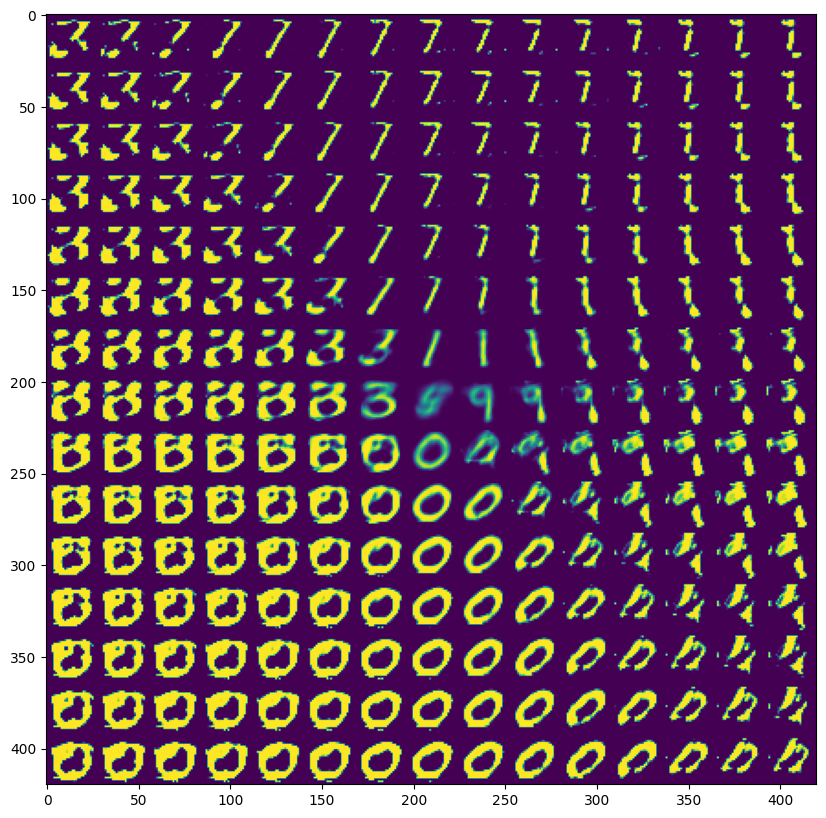

In [ ]:
import matplotlib.pyplot as plt

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Y con esto, tenemos nuestro primer VAE implementado.

Sin embargo, como podéis ver, no funciona demasiado bien.

**Pregunta**: ¿Por qué creéis que nuestro auto-encoder no funciona demasiado bien?

**Respuesta**: Si os fijáis, las imágenes del centro se ven bastante bien, y conforme nos alejamos del centro $(0, 0)$, empeora la calidad. Esto se debe a que se han muestrado las imágenes de entrada en el espacio latente en un rango más pequeño, entre -4 y 4 aproximadamente.

El siguiente gráfico lo demuestra:

313/313 [==============================] - 0s 1ms/step


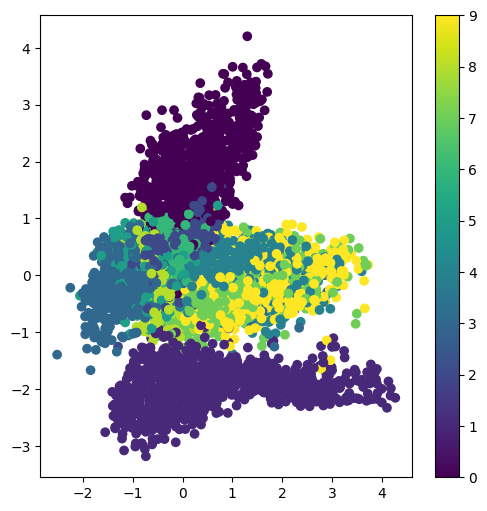

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=32)
x_test_encoded = np.asarray(x_test_encoded)

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_test)
plt.colorbar()
plt.show()

Probemos a "muestrear" de un espacio más reducido, por ejemplo, desde -5 a 5.

1/1 [==============================] - 0s 16ms/step


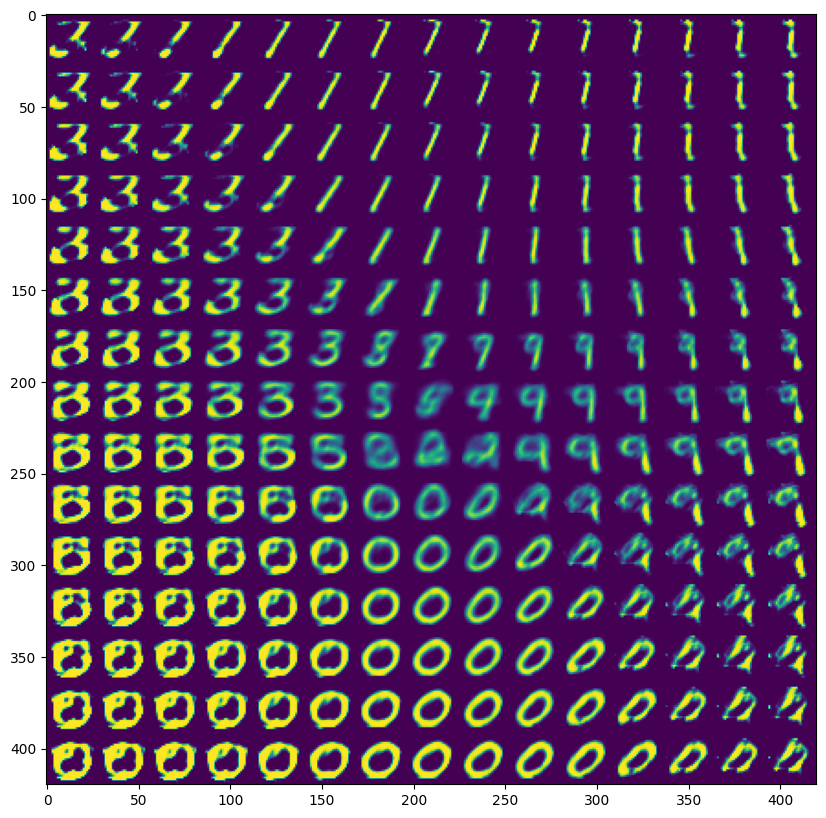

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-5, 5] standard deviations
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [ ]:
from scipy.stats import norm
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

1/1 [==============================] - 0s 17ms/step


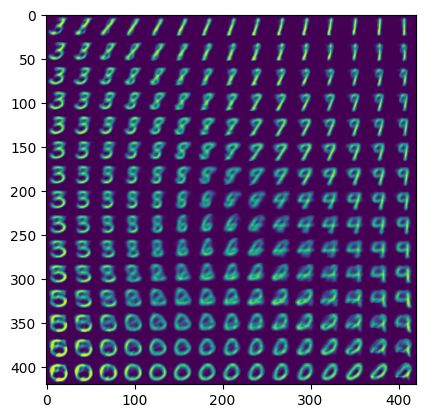

In [ ]:
plt.imshow(figure)
plt.show()

Además, el hecho de dejar únicamente 2 dimensiones en el espacio latente también le complica el trabajo al VAE, pero lo hacemos así para poder visualizar correctamente los resultados.

Por último, también podríamos probar con una arquitectura más compleja, ya que la que hemos usado antes es muy sencilla.

**Ejercicio**

Prueba a encontrar una arquitectura que mejore la distribución del espacio latente.

Epoch 1/30
1875/1875 [==============================] - 9s 4ms/step - loss: 189.5408 - val_loss: 169.6643
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 167.5598 - val_loss: 164.2629
Epoch 3/30
1875/1875 [==============================] - 8s 4ms/step - loss: 163.1129 - val_loss: 160.4916
Epoch 4/30
1875/1875 [==============================] - 7s 4ms/step - loss: 159.8638 - val_loss: 158.1973
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 157.5428 - val_loss: 156.1110
Epoch 6/30
1875/1875 [==============================] - 8s 4ms/step - loss: 155.9816 - val_loss: 154.9369
Epoch 7/30
1875/1875 [==============================] - 6s 3ms/step - loss: 154.8286 - val_loss: 154.1677
Epoch 8/30
1875/1875 [==============================] - 8s 4ms/step - loss: 153.8866 - val_loss: 153.2381
Epoch 9/30
1875/1875 [==============================] - 6s 3ms/step - loss: 153.0875 - val_loss: 152.3766
Epoch 10/30
1875/1875 [=======================

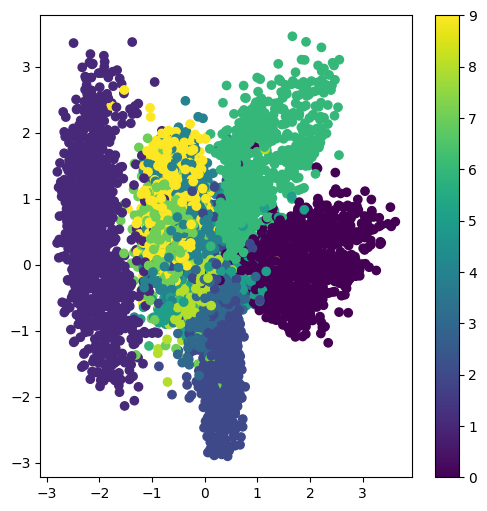

In [ ]:
import keras
from keras import layers
from keras import backend as K
import numpy as np
from keras.datasets import mnist

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

# encoder
inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])


# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')


# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

# loss function
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# get the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# train the model
vae.fit(x_train, x_train,
        epochs=30,
        batch_size=32,
        validation_data=(x_test, x_test))

# visualize latent space
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=32)
x_test_encoded = np.asarray(x_test_encoded)

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_test)
plt.colorbar()
plt.show()


### Recursos interesantes:

###

- [Variational Autoencoders](https://www.jeremyjordan.me/variational-autoencoders/)

- [Conditional VAE](https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb)

- [Explicación en profundidad](https://jaketae.github.io/study/vae/)